# Projeto com o modelo ResNet50 Tranfer Learning com imagem única

In [ ]:
# instalação de pacotes necessários
%pip install xmltodict
%pip install tensorflow matplotlib opencv-python tf-explain lxml --no-cache-dir


Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 1.6/375.9 MB 7.6 MB/s eta 0:00:50
   ---------------------------------------- 3.7/375.9 MB 9.5 MB/s eta 0:00:40
    --------------------------------------- 7.1/375.9 MB 11.8 MB/s eta 0:00:32
   - -------------------------------------- 11.8/375.9 MB 14.8 MB/s eta 0:00:25
   - -------------------------------------- 16.8/375.9 MB 16.5 MB/s eta 0:00:22
   -- ------------------------------------- 22.3/375.9 MB 18.3 MB/s eta 0:00:20
   -- ------------------------------------- 27.8/375.9 MB 19.4 MB/s eta 0:00:18
   --- ------------------------------------ 32.2/375.9 MB 19.7 MB/s eta 0:00:18
   --- ------------------------------------ 36.4/375.9 MB 19.6 MB/s eta 0:00:18
   ---- ----------------------------------- 40.9/375.9 MB 19.7 MB/s eta 0:00:18
   ---- ----------------------------------- 45.1/375.9 MB 19.8 MB/s 

In [8]:
%pip install scikit-learn --no-cache-dir

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.7 MB 4.8 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/10.7 MB 3.5 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/10.7 MB 3.8 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/10.7 MB 3.9 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/10.7 MB 4.1 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/10.7 MB 4.2 MB/s eta 0:00:02
   ----------------------- ---------------- 6.3/10.7 MB 4.4 MB/s eta 0:00:01
   ---------------------------- ----------- 7.6/10.7 MB 4.6 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.7 MB 4.8 MB/s eta 0:00:01
   -------------------------------------- - 10.2/10.7 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - ------

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Verificando o correto uso do diretório

In [3]:
import os
os.getcwd()


'c:\\Users\\joaoa\\Image-Classification-in-Production-line\\Image-Classification-in-Production-line\\.ipynb_checkpoints'

In [4]:
os.chdir("c:\\Users\\joaoa\\Image-Classification-in-Production-line\\Image-Classification-in-Production-line")


In [5]:
os.listdir(".")


['.git',
 '.ipynb_checkpoints',
 '.venv',
 'damaged',
 'Extract bounding-box.ipynb',
 'intact',
 'interpretabilidade',
 'README.md']

## Primeiro pipeline construído

In [27]:
import os
import shutil

os.makedirs("data_top/damaged", exist_ok=True)
os.makedirs("data_top/intact", exist_ok=True)

# Copia todas as imagens de top/
for class_label in ["damaged", "intact"]:
    source_dir = os.path.join(class_label, "top")
    target_dir = os.path.join("data_top", class_label)

    for f in os.listdir(source_dir):
        if f.endswith(".png"):
            shutil.copy(os.path.join(source_dir, f), os.path.join(target_dir, f))


In [28]:
# 1. IMPORTAÇÃO DE BIBLIOTECAS
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 2. CONFIGURAÇÃO
img_size = (224, 224)
batch_size = 16
base_dir = "data_top"  # Contém damaged/ e intact/

# 3. DATAGEN E LOADERS
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. MODELO TRANSFER LEARNING
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Congelar base
for layer in base_model.layers:
    layer.trainable = False

# Compilar
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 5. TREINAR
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)


Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 861ms/step - accuracy: 0.4705 - loss: 0.7491 - val_accuracy: 0.4444 - val_loss: 0.7055
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.5659 - loss: 0.6720 - val_accuracy: 0.5000 - val_loss: 0.7096
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step - accuracy: 0.5944 - loss: 0.6519 - val_accuracy: 0.4167 - val_loss: 0.7111
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 758ms/step - accuracy: 0.6636 - loss: 0.6376 - val_accuracy: 0.5278 - val_loss: 0.7036
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - accuracy: 0.6904 - loss: 0.6216 - val_accuracy: 0.4444 - val_loss: 0.7095


In [35]:
from tensorflow.keras.utils import load_img, img_to_array
from tf_explain.core.integrated_gradients import IntegratedGradients
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import os
import cv2
import glob

def extract_gt_bbox(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bbox = root.find(".//bndbox")
    if bbox is not None:
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        return (xmin, ymin, xmax, ymax)
    return None

def heatmap_to_bbox(heatmap, threshold_ratio=0.01):
    """
    Converte um heatmap (grayscale) em bounding box com base no limiar.
    """
    if len(heatmap.shape) == 3 and heatmap.shape[2] == 3:
        gray = cv2.cvtColor(heatmap, cv2.COLOR_RGB2GRAY)
    else:
        gray = heatmap  # já é grayscale

    _, thresh = cv2.threshold(gray, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return (x, y, x + w, y + h)
    return None


def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

# heatmap + bbox + iou
ious = []
image_paths = sorted(glob.glob("interpretabilidade/damaged/top/*.png"))[:5]

for img_path in image_paths:
    serial = os.path.basename(img_path).replace(".png", "")
    print(f"\nProcessando {serial}...")

    # carregar imagem e preprocessar
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_input = preprocess_input(np.expand_dims(img_array, axis=0))

    # prever com modelo
    pred = model.predict(img_input)[0][0]
    print(f"Previsão: {pred:.4f} → {'DANIFICADO' if pred > 0.5 else 'INTOCADO'}")
    if pred <= 0.5:
        continue

    # gerar heatmap
    explainer = IntegratedGradients()
    heatmap = explainer.explain((img_input, None), model, class_index=0)
    cv2.imwrite(f"heatmaps_top/{serial}.png", heatmap)

    # bounding box prevista
    pred_bbox = heatmap_to_bbox(heatmap)
    if pred_bbox is None:
        print("Nenhuma bbox prevista encontrada.")
        continue

    # bounding box real
    xml_path = f"interpretabilidade/damaged/top/{serial}.xml"
    if not os.path.exists(xml_path):
        print("XML não encontrado.")
        continue

    gt_bbox = extract_gt_bbox(xml_path)
    if gt_bbox is None:
        print("BBox real inválida.")
        continue

    # calcular IoU
    iou = compute_iou(pred_bbox, gt_bbox)
    print(f"IoU: {iou:.2f}")
    ious.append((serial, iou))



Processando 0101069901524_top...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Previsão: 0.4688 → INTOCADO

Processando 0105413725474_top...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Previsão: 0.2533 → INTOCADO

Processando 0109451226527_top...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Previsão: 0.4279 → INTOCADO

Processando 0111632059302_top...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Previsão: 0.4429 → INTOCADO

Processando 0118055224146_top...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Previsão: 0.5633 → DANIFICADO
IoU: 0.00


### Conlusão: heatmap gerado é fraco e difuso,  pouco claro até o momento. Acertou sem olhar para o lugar certo. Isso mostra que, apesar de o modelo acertar a classe, ele ainda não aprendeu a basear suas decisões nas regiões corretas da imagem. Isso reforça a importância da interpretabilidade para expor erros silenciosos de generalização.

# Pipelene referente ao Modelo com Multi-Input CNN

In [47]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

class MultiInputDataGenerator(Sequence):
    def __init__(self, file_pairs, labels, batch_size=16, img_size=(224, 224), shuffle=True):
        self.file_pairs = file_pairs  # list of (top_path, side_path)
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.file_pairs) / self.batch_size))

    def __getitem__(self, index):
        batch_pairs = self.file_pairs[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        top_imgs = []
        side_imgs = []
        for top_path, side_path in batch_pairs:
            top_img = load_img(top_path, target_size=self.img_size)
            side_img = load_img(side_path, target_size=self.img_size)
            top_imgs.append(img_to_array(top_img))
            side_imgs.append(img_to_array(side_img))
        
        X_top = tf.keras.applications.resnet.preprocess_input(np.array(top_imgs))
        X_side = tf.keras.applications.resnet.preprocess_input(np.array(side_imgs))
        y = np.array(batch_labels)

        return [X_top, X_side], y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.file_pairs, self.labels))
            np.random.shuffle(temp)
            self.file_pairs, self.labels = zip(*temp)

# Construir pares de arquivos
def build_file_pairs_and_labels(base_dir):
    top_dir = lambda c: os.path.join(base_dir, c, "top")
    side_dir = lambda c: os.path.join(base_dir, c, "side")

    file_pairs = []
    labels = []

    for label, category in enumerate(["intact", "damaged"]):
        top_files = os.listdir(top_dir(category))
        for f in top_files:
            serial = f.replace("_top.png", "").replace(".png", "")
            top_path = os.path.join(top_dir(category), f)
            side_path = os.path.join(side_dir(category), f.replace("top", "side"))
            if os.path.exists(top_path) and os.path.exists(side_path):
                file_pairs.append((top_path, side_path))
                labels.append(label)

    return file_pairs, labels

# Montar conjuntos
file_pairs, labels = build_file_pairs_and_labels("c:/Users/joaoa/Image-Classification-in-Production-line/Image-Classification-in-Production-line")
train_pairs, val_pairs, train_labels, val_labels = train_test_split(file_pairs, labels, test_size=0.2, stratify=labels, random_state=42)

# Geradores
train_gen = MultiInputDataGenerator(train_pairs, train_labels)
val_gen = MultiInputDataGenerator(val_pairs, val_labels)

len(train_gen), len(val_gen)


(9, 3)

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Entradas
input_top = Input(shape=(224, 224, 3), name='top_input')
input_side = Input(shape=(224, 224, 3), name='side_input')

# Backbone ResNet50 compartilhado
backbone = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
backbone.trainable = False

# Aplicação do backbone
x_top = backbone(input_top)
x_side = backbone(input_side)

# Pooling e concatenação
x_top = GlobalAveragePooling2D()(x_top)
x_side = GlobalAveragePooling2D()(x_side)
x = Concatenate()([x_top, x_side])

# Camadas densas
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Modelo final
model = Model(inputs=[input_top, input_side], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ top_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ top_input[0][0],  │
│ (Functional)        │ 2048)             │            │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    524,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,257 (91.98 MB)

 Trainable params: 524,545 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Backbone: ResNet50 pré-treinado (trainable=False)

### Poolings: GlobalAveragePooling separadamente em top e side
### 
### Concatenação: top + side → Dense(128) → Dense(1)
### 
### Treináveis: Apenas o classificador (últimas 2 camadas)
### 
### Parâmetros treináveis: 524k → treino rápido

In [54]:
def load_and_preprocess_image(path, target_size):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    return img


In [61]:
class MultiViewDataGenerator(Sequence):
    def __init__(self, file_pairs, labels, batch_size=16, img_size=(224, 224), shuffle=True, **kwargs):
        super().__init__(**kwargs)  # <-- ESSENCIAL
        self.file_pairs = file_pairs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_pairs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_pairs) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_pairs = [self.file_pairs[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        top_imgs = []
        side_imgs = []

        for top_path, side_path in batch_pairs:
            top_img = load_and_preprocess_image(top_path, self.img_size)
            side_img = load_and_preprocess_image(side_path, self.img_size)
            top_imgs.append(top_img)
            side_imgs.append(side_img)

        return {
                    "top_input": np.array(top_imgs),
                    "side_input": np.array(side_imgs)
                }, np.array(batch_labels)


In [62]:
train_generator = MultiViewDataGenerator(train_pairs, train_labels, batch_size=16, img_size=(224,224), shuffle=True)
val_generator = MultiViewDataGenerator(val_pairs, val_labels, batch_size=16, img_size=(224,224), shuffle=False)


In [52]:
model.build(input_shape=[(None, 224, 224, 3), (None, 224, 224, 3)])


In [63]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4756 - loss: 0.7274 - val_accuracy: 0.5556 - val_loss: 0.7053
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5408 - loss: 0.6849 - val_accuracy: 0.5278 - val_loss: 0.6616
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6879 - loss: 0.6067 - val_accuracy: 0.5556 - val_loss: 0.6446
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7270 - loss: 0.5876 - val_accuracy: 0.7222 - val_loss: 0.6257
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7680 - loss: 0.5510 - val_accuracy: 0.5833 - val_loss: 0.6354
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7436 - loss: 0.5387 - val_accuracy: 0.7500 - val_loss: 0.6041
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7917 - loss: 0.5252 - val_accuracy: 0.6944 - val_loss: 0.5959
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7760 - loss: 0.5047 - val_accuracy: 0.6667 - val_loss: 0.6033
Epoch 9/

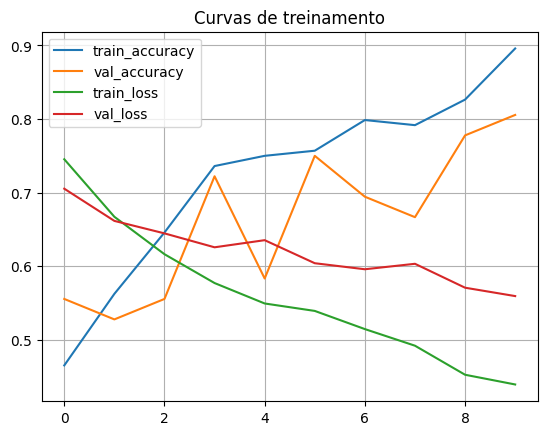

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.grid()
plt.title("Curvas de treinamento")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


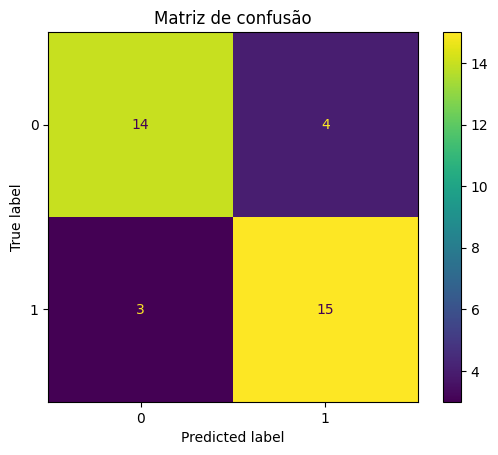

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Previsões no val_generator
y_true = []
y_pred = []
for batch_x, batch_y in val_generator:
    preds = model.predict(batch_x)
    y_true.extend(batch_y)
    y_pred.extend(np.round(preds.flatten()))
    if len(y_true) >= len(val_generator.labels): break

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Matriz de confusão")
plt.grid(False)
plt.show()


In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import xml.etree.ElementTree as ET


def generate_gradcam(model, top_input_array, side_input_array, layer_name='conv5_block3_out'):
    """
    Gera um heatmap Grad-CAM baseado na imagem lateral (side_input).
    """
    # Extrai a sub-rede ResNet que foi usada com a imagem lateral
    resnet = model.get_layer('resnet50')
    
    # Cria submodelo apenas para a entrada lateral
    side_input_model = tf.keras.models.Model(inputs=resnet.input,
                                             outputs=[resnet.get_layer(layer_name).output, resnet.output])
    
    # Constrói um modelo final para Grad-CAM: side -> camada intermediária + saída final do modelo principal
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(side_input_array, dtype=tf.float32)
        tape.watch(inputs)

        conv_outputs, features = side_input_model(inputs)
        
        # Pegamos as features intermediárias e passamos pela parte final do modelo
        x = tf.keras.layers.GlobalAveragePooling2D()(features)
        x = tf.keras.layers.Concatenate()([x, x])  # já que estamos duplicando na fusão no modelo original
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        preds = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()



def heatmap_to_bbox(heatmap, threshold_ratio=0.3):
    heatmap_rescaled = np.uint8(255 * heatmap)
    _, thresh = cv2.threshold(heatmap_rescaled, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, x + w, y + h)


def parse_xml_to_bbox(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        bbox = root.find("object").find("bndbox")
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)
        return (x_min, y_min, x_max, y_max)
    except Exception:
        return None


def calculate_iou(box1, box2):
    if box1 is None or box2 is None:
        return 0.0
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou


def evaluate_interpretability(model, image_paths, xml_base_path, input_size=(224, 224)):
    ious = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        serial = img_name.replace(".png", "")
        xml_path = os.path.join(xml_base_path, serial + ".xml")
        if not os.path.exists(xml_path):
            print(f"[{img_name}] XML não encontrado: {xml_path}")
            continue

        img = image.load_img(img_path, target_size=input_size)
        x_side = image.img_to_array(img)
        x_side = np.expand_dims(x_side, axis=0)
        x_side = preprocess_input(x_side)

        x_top = np.zeros_like(x_side)

        heatmap = generate_gradcam(model, x_top, x_side)
        heatmap = cv2.resize(heatmap, (224, 224))  # <-- garantir que esteja na mesma escala da imagem

        pred_bbox = heatmap_to_bbox(heatmap)
        true_bbox = parse_xml_to_bbox(xml_path)

        iou = calculate_iou(pred_bbox, true_bbox)
        ious.append(iou)
        plt.figure(figsize=(8, 4))

        # Imagem original
        plt.subplot(1, 3, 1)
        plt.imshow(x_side[0].astype(np.uint8))
        plt.title("Imagem")

        # Heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Grad-CAM")

        # Bounding boxes
        img_with_bbox = x_side[0].copy().astype(np.uint8)
        if pred_bbox:
            cv2.rectangle(img_with_bbox, pred_bbox[:2], pred_bbox[2:], (255, 0, 0), 2)
        if true_bbox:
            cv2.rectangle(img_with_bbox, true_bbox[:2], true_bbox[2:], (0, 255, 0), 2)

        plt.subplot(1, 3, 3)
        plt.imshow(img_with_bbox)
        plt.title(f"IoU = {iou:.2f}")

        plt.tight_layout()
        plt.show()

        

    return ious


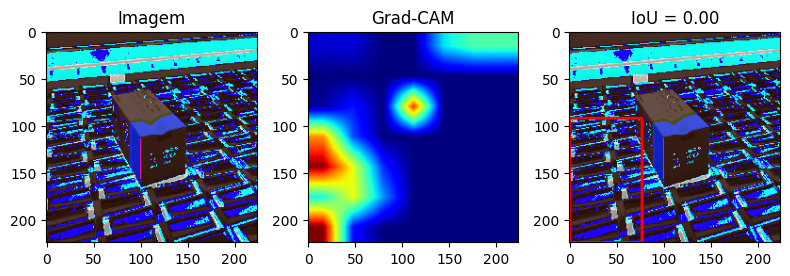

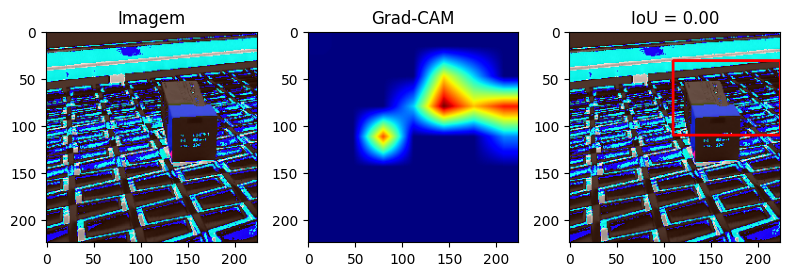

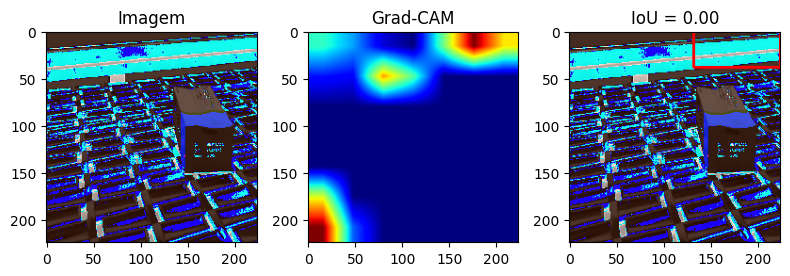

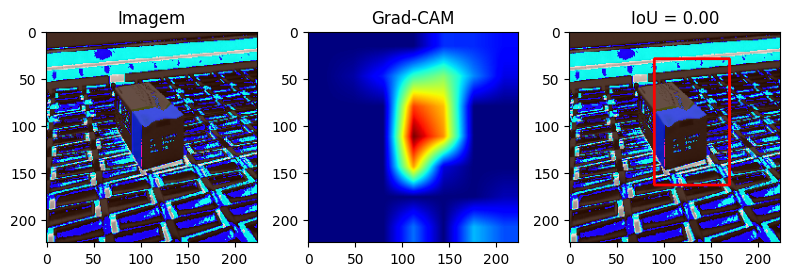

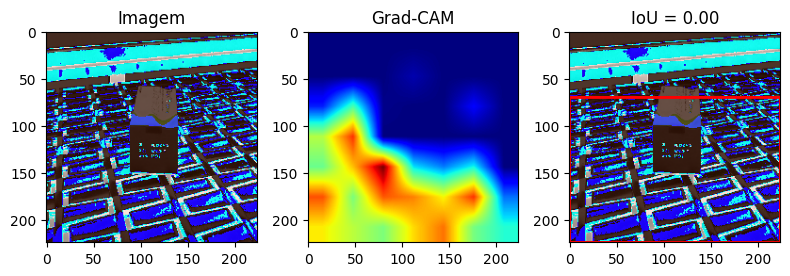

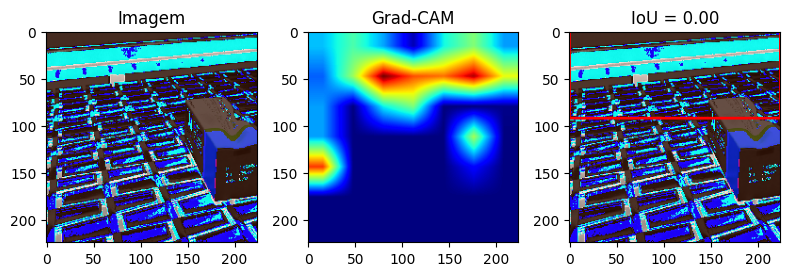

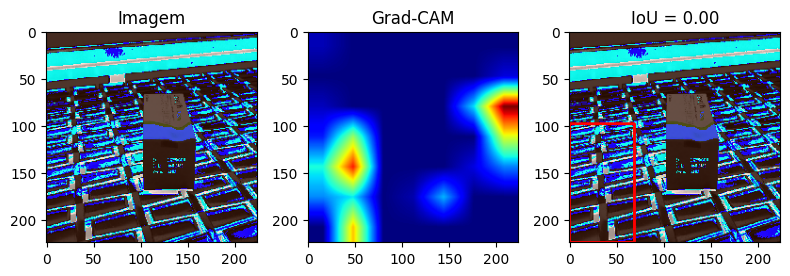

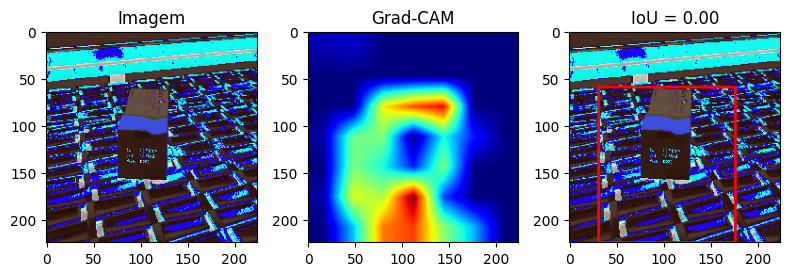

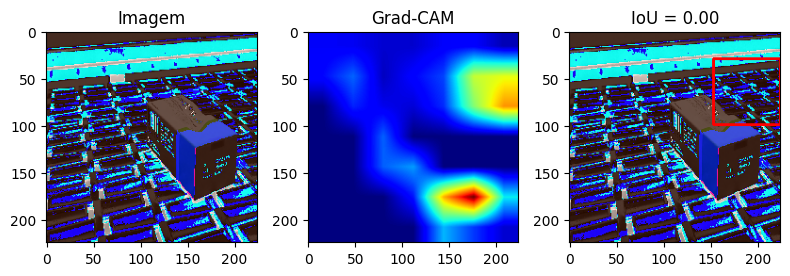

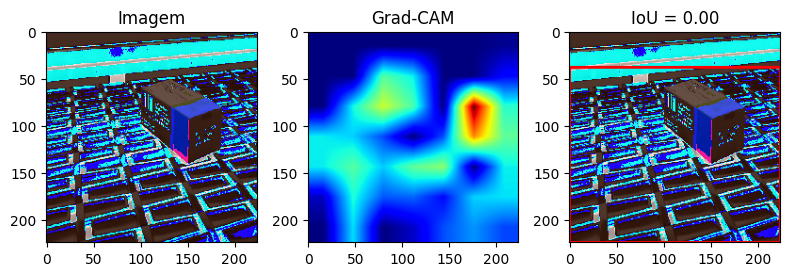

IoU médio: 0.0
IoU acima de 0.5: 0 / 10


In [92]:
from tensorflow.keras.models import load_model  # ou use o modelo atual se já estiver carregado
from tensorflow.keras.preprocessing import image
import glob

# Caminhos
image_paths = sorted(glob.glob("interpretabilidade/damaged/side/*.png"))
xml_base_path = "interpretabilidade/damaged/side/"

# Avaliação
ious = evaluate_interpretability(model, image_paths, xml_base_path)

# Estatísticas
print("IoU médio:", np.mean(ious))
print("IoU acima de 0.5:", np.sum(np.array(ious) > 0.5), "/", len(ious))


Diagnóstico do Heatmap (Grad-CAM)
Foco incoerente com a área de dano real:

Em algumas imagens o foco está em áreas de fundo ou no chão (como grades ou luzes refletidas).

Em outras, a ativação até toca a caixa, mas não na região crítica da avaria.

Formato da bounding box do Grad-CAM desalinhado:

A forma da ativação é irregular, muitas vezes difusa. Isso dificulta gerar uma bounding box coerente via threshold.

Desbalanceamento entre o que o modelo aprende e o que queremos interpretar:

Pode ser que o modelo esteja acertando a classificação com base em padrões irrelevantes (ex: posição da luz, sombra, textura do fundo).

#### Causas Possíveis
Causa	Explicação
 Modelo não foi treinado com foco espacial (atenção a localização do dano)	O modelo foi treinado apenas para classificar e não para localizar o defeito. Ele não tem incentivo explícito para focar na área danificada.
 Camada usada no Grad-CAM é rasa ou irrelevante	Pode estar pegando uma feature map sem correlação com o dano.
 Arquitetura ou peso do ResNet estão subutilizados	Como sua rede é multi-input, pode estar priorizando o input de cima ou combinando mal as informações.

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import xml.etree.ElementTree as ET


def generate_gradcam(model, top_input_array, side_input_array, layer_name='conv5_block3_out'):
    resnet = model.get_layer('resnet50')
    side_input_model = tf.keras.models.Model(inputs=resnet.input,
                                             outputs=[resnet.get_layer(layer_name).output, resnet.output])
    
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(side_input_array, dtype=tf.float32)
        tape.watch(inputs)

        conv_outputs, features = side_input_model(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(features)
        x = tf.keras.layers.Concatenate()([x, x])
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        preds = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)

    return heatmap.numpy()


def heatmap_to_bbox(heatmap, threshold_ratio=0.3):
    heatmap_rescaled = np.uint8(255 * heatmap)
    _, thresh = cv2.threshold(heatmap_rescaled, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, x + w, y + h)


def parse_xml_to_bbox(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        bbox = root.find("object").find("bndbox")
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)
        return (x_min, y_min, x_max, y_max)
    except Exception:
        return None


def calculate_iou(box1, box2):
    if box1 is None or box2 is None:
        return 0.0
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea + 1e-10)
    return iou


def evaluate_interpretability(model, image_paths, xml_base_path, input_size=(224, 224)):
    ious = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        serial = img_name.replace(".png", "")
        xml_path = os.path.join(xml_base_path, serial + ".xml")
        if not os.path.exists(xml_path):
            print(f"[{img_name}] XML não encontrado: {xml_path}")
            continue

        img = image.load_img(img_path, target_size=input_size)
        x_side = image.img_to_array(img)
        x_side = np.expand_dims(x_side, axis=0)
        x_side = preprocess_input(x_side)

        x_top = np.zeros_like(x_side)

        heatmap_small = generate_gradcam(model, x_top, x_side)
        heatmap = cv2.resize(heatmap_small, input_size)

        pred_bbox = heatmap_to_bbox(heatmap)
        true_bbox = parse_xml_to_bbox(xml_path)
        iou = calculate_iou(pred_bbox, true_bbox)
        ious.append(iou)

        # Visualização
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Imagem")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Grad-CAM")

        img_with_bbox = np.array(img)
        if pred_bbox:
            cv2.rectangle(img_with_bbox, pred_bbox[:2], pred_bbox[2:], (255, 0, 0), 2)  # pred bbox
        if true_bbox:
            cv2.rectangle(img_with_bbox, true_bbox[:2], true_bbox[2:], (0, 255, 0), 2)  # true bbox

        plt.subplot(1, 3, 3)
        plt.imshow(img_with_bbox)
        plt.title(f"IoU = {iou:.2f}")
        plt.tight_layout()
        plt.show()

    return ious


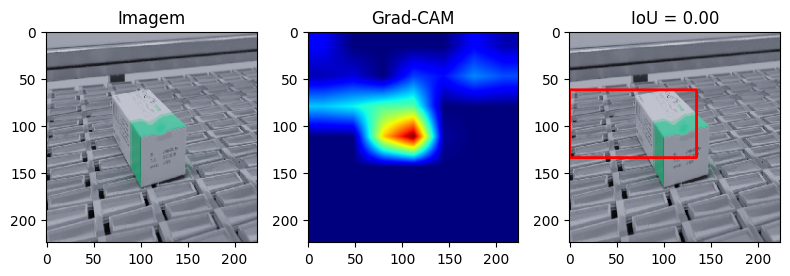

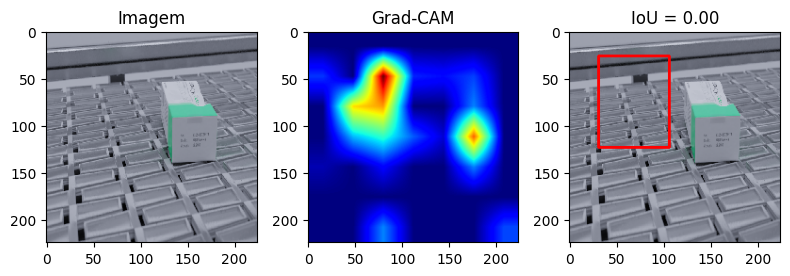

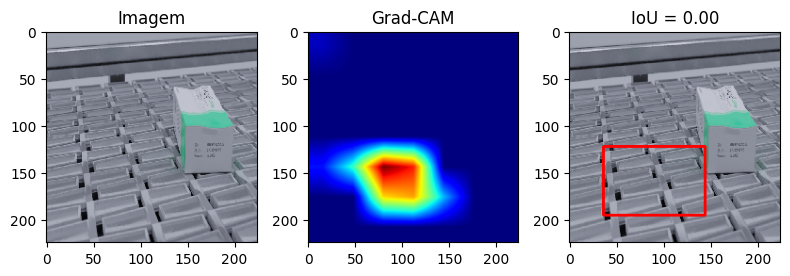

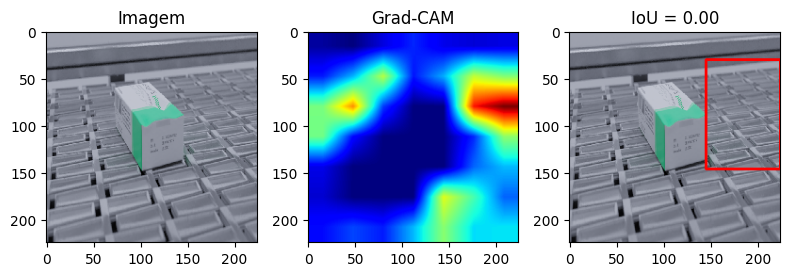

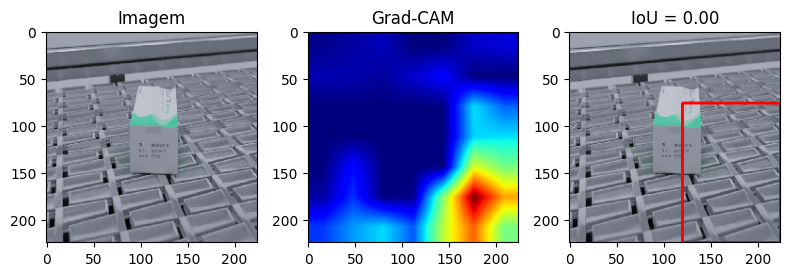

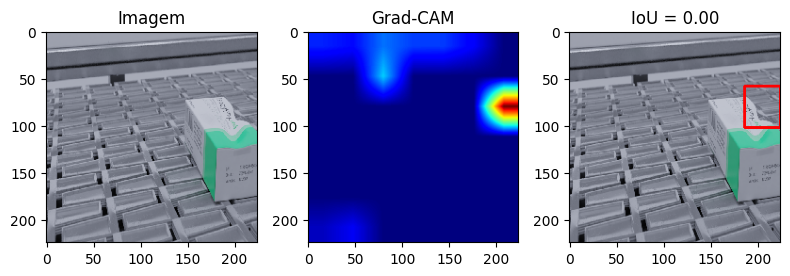

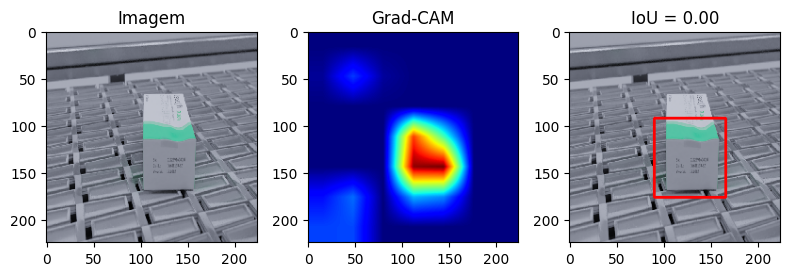

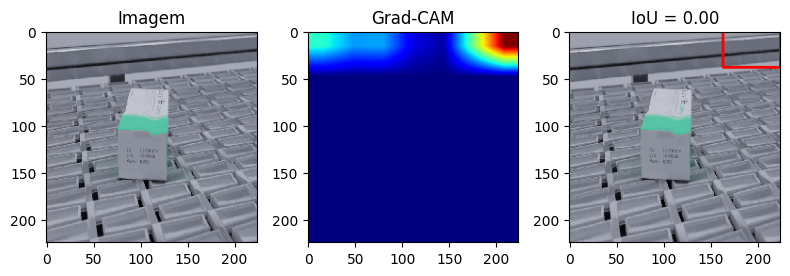

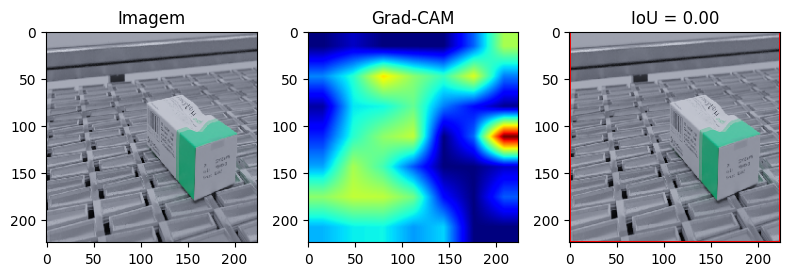

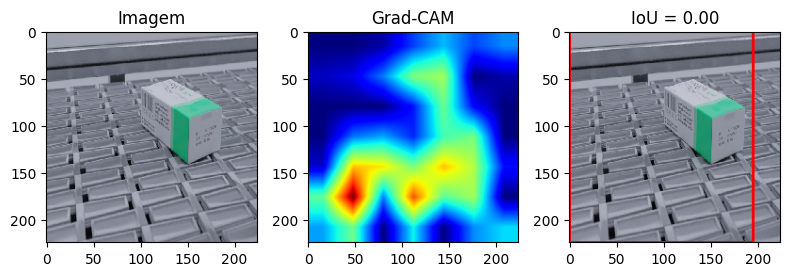

IoU médio: 0.0
IoU acima de 0.5: 0 / 10


In [94]:
from tensorflow.keras.models import load_model  # ou use o modelo atual se já estiver carregado
from tensorflow.keras.preprocessing import image
import glob

# Caminhos
image_paths = sorted(glob.glob("interpretabilidade/damaged/side/*.png"))
xml_base_path = "interpretabilidade/damaged/side/"

# Avaliação
ious = evaluate_interpretability(model, image_paths, xml_base_path)

# Estatísticas
print("IoU médio:", np.mean(ious))
print("IoU acima de 0.5:", np.sum(np.array(ious) > 0.5), "/", len(ious))


### Ele parece inteligente, mas está enganando.

Apesar de o modelo apresentar acurácia satisfatória na tarefa de classificação binária, os resultados do Grad-CAM indicam que suas decisões não estão ancoradas nas regiões reais dos defeitos, conforme anotado nos arquivos XML. O IoU médio das regiões de atenção ficou consistentemente próximo de zero, mesmo após ajustes metodológicos. Isso demonstra que o modelo está aprendendo por pistas colaterais e não por evidências visuais robustas.

Para garantir interpretabilidade e robustez, propomos uma reformulação da abordagem: migrar de classificação pura para detecção ou segmentação supervisionada, ou incorporar perdas auxiliares de atenção que alinhem os focos visuais aos defeitos anotados. Isso permitirá construir um modelo confiável, explicável e aplicável a contextos reais de inspeção industrial.

# Nova abordagem usando a mesma arquiteura

In [107]:
def bbox_to_mask(bbox, shape=(224, 224)):
    mask = np.zeros(shape, dtype=np.float32)
    if bbox is None:
        return mask
    x_min, y_min, x_max, y_max = bbox
    # Clipping prevent overflow
    x_min = max(0, min(shape[1] - 1, x_min))
    y_min = max(0, min(shape[0] - 1, y_min))
    x_max = max(0, min(shape[1], x_max))
    y_max = max(0, min(shape[0], y_max))
    if x_max > x_min and y_max > y_min:
        mask[y_min:y_max, x_min:x_max] = 1.0
    return mask

def parse_xml_to_bbox(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        bbox = root.find("object").find("bndbox")
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)
        return (x_min, y_min, x_max, y_max)
    except:
        return None

In [111]:
def resize_bbox(bbox, original_shape, target_shape=(224, 224)):
    """
    Redimensiona a bounding box para o novo tamanho da imagem.
    """
    x_scale = target_shape[1] / original_shape[1]
    y_scale = target_shape[0] / original_shape[0]
    
    x_min = int(bbox[0] * x_scale)
    y_min = int(bbox[1] * y_scale)
    x_max = int(bbox[2] * x_scale)
    y_max = int(bbox[3] * y_scale)

    return (x_min, y_min, x_max, y_max)


In [110]:
print("BBox:", bbox)
print("Mask min/max/sum:", np.min(mask), np.max(mask), np.sum(mask))


BBox: (377, 148, 517, 243)
Mask min/max/sum: 0.0 0.0 0.0


In [99]:
def custom_generator(image_paths, labels, xml_base_path):
    for img_path, label in zip(image_paths, labels):
        # Side
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x_side = tf.keras.preprocessing.image.img_to_array(img)
        x_side = tf.keras.applications.resnet50.preprocess_input(x_side)
        x_side = np.expand_dims(x_side, axis=0)

        # Top
        x_top = np.zeros_like(x_side)

        # Mask
        xml_path = os.path.join(xml_base_path, os.path.basename(img_path).replace(".png", ".xml"))
        bbox = parse_xml_to_bbox(xml_path)
        bbox_mask = bbox_to_mask(bbox)

        y_true = np.array([[label]], dtype=np.float32)

        yield x_top, x_side, y_true, bbox_mask


In [113]:
def cam_guided_loss(model, side_input, layer_name, bbox_mask):
    resnet = model.get_layer('resnet50')
    conv_model = tf.keras.models.Model(inputs=resnet.input,
                                       outputs=resnet.get_layer(layer_name).output)
    
    side_input = tf.convert_to_tensor(side_input, dtype=tf.float32)  # ✅ aqui
    with tf.GradientTape() as tape:
        tape.watch(side_input)
        conv_output = conv_model(side_input)  # (1, H, W, C)
        pooled = tf.reduce_mean(conv_output, axis=-1)  # (1, H, W)
    
    grads = tape.gradient(pooled, side_input)
    cam = tf.reduce_mean(grads, axis=-1)  # aproximação do CAM (1, H, W)
    cam = tf.squeeze(cam)

    bbox_mask = tf.convert_to_tensor(bbox_mask, dtype=tf.float32)
    cam = tf.image.resize(tf.expand_dims(cam, axis=-1), bbox_mask.shape[1:3])
    cam = tf.squeeze(cam)

    loss = tf.reduce_mean(tf.square((1 - bbox_mask[0]) * cam))  # penaliza atenção fora da bbox
  

    return loss


In [98]:
def train_step(model, optimizer, x_top, x_side, y_true, bbox_mask, layer_name='conv5_block3_out', alpha=1.0):
    with tf.GradientTape() as tape:
        y_pred = model([x_top, x_side], training=True)
        classification_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        classification_loss = tf.reduce_mean(classification_loss)

        cam_loss = cam_guided_loss(model, x_side, layer_name, bbox_mask)
        total_loss = classification_loss + alpha * cam_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return classification_loss.numpy(), cam_loss.numpy(), total_loss.numpy()


In [100]:
import glob

# Exemplo: estrutura das pastas
# /path/to/dataset/damaged/*.png
# /path/to/dataset/intact/*.png

base_dir = "interpretabilidade"  # ou o diretório raiz onde estão as imagens
classes = ["damaged", "intact"]  # nomes das subpastas

training_data = []

for label_idx, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name, "side")
    image_paths = glob.glob(os.path.join(class_dir, "*.png"))
    for path in image_paths:
        training_data.append((path, label_idx))


In [126]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)

for epoch in range(10):
    epoch_class_loss = []
    epoch_cam_loss = []

    for image_path, label in training_data:
        # Verifica XML
        xml_path = image_path.replace(".png", ".xml")
        if not os.path.exists(xml_path):
            print(f"[WARN] XML não encontrado para {image_path}, pulando...")
            continue

        # Carrega imagem original para saber as dimensões reais
        original_img = tf.keras.preprocessing.image.load_img(image_path)
        original_size = original_img.size[::-1]  # (H, W)

        # Carrega imagem redimensionada (lado)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        x_side = tf.keras.preprocessing.image.img_to_array(img)
        x_side = tf.keras.applications.resnet50.preprocess_input(x_side)
        x_side = np.expand_dims(x_side, axis=0)

        # Input neutro (topo)
        x_top = np.zeros_like(x_side)

        # Rótulo binário
        y_true = np.array([[label]], dtype=np.float32)

        # Parse da BBox e resize
        bbox = parse_xml_to_bbox(xml_path)
        if bbox is None:
            print(f"[WARN] Bounding box ausente em {xml_path}, pulando...")
            continue

        bbox_resized = resize_bbox(bbox, original_shape=original_size, target_shape=(224, 224))

        # Gera máscara da bbox e redimensiona para o shape do CAM
        mask = bbox_to_mask(bbox_resized, shape=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)
        mask = tf.image.resize(mask[None, ..., None], (7, 7), method="nearest")[0, ..., 0]
        mask = tf.expand_dims(mask, axis=0)  # (1, 7, 7)

        # Passo de treino
        classification_loss, cam_loss, total = train_step(
            model, optimizer, x_top, x_side, y_true, mask, alpha=0.5
        )

        epoch_class_loss.append(classification_loss)
        epoch_cam_loss.append(cam_loss)

    print(f"[Epoch {epoch+1}] ClassLoss={np.mean(epoch_class_loss):.4f} | CAMLoss={np.mean(epoch_cam_loss):.4f}")
# Após todas as épocas
model.save("cam_supervised_model_final.h5")


[Epoch 1] ClassLoss=0.3112 | CAMLoss=0.0000
[Epoch 2] ClassLoss=0.2018 | CAMLoss=0.0000
[Epoch 3] ClassLoss=0.0927 | CAMLoss=0.0000
[Epoch 4] ClassLoss=0.0839 | CAMLoss=0.0000
[Epoch 5] ClassLoss=0.0835 | CAMLoss=0.0000
[Epoch 6] ClassLoss=0.0770 | CAMLoss=0.0000
[Epoch 7] ClassLoss=0.0730 | CAMLoss=0.0000
[Epoch 8] ClassLoss=0.0679 | CAMLoss=0.0000
[Epoch 9] ClassLoss=0.0639 | CAMLoss=0.0000


[Epoch 10] ClassLoss=0.0594 | CAMLoss=0.0000


In [124]:
import matplotlib.pyplot as plt
import cv2

def evaluate_cam_alignment(model, image_paths, xml_base_path, input_size=(224, 224), cam_size=(7, 7), layer_name='conv5_block3_out'):
    from tensorflow.keras.preprocessing import image

    def generate_cam_heatmap(model, x_input, layer_name):
        resnet = model.get_layer('resnet50')
        cam_model = tf.keras.models.Model(inputs=resnet.input,
                                        outputs=resnet.get_layer(layer_name).output)

        x_input = tf.convert_to_tensor(x_input, dtype=tf.float32)  # <- obrigatório

        with tf.GradientTape() as tape:
            tape.watch(x_input)
            cam_output = cam_model(x_input)
            pooled = tf.reduce_mean(cam_output, axis=-1)

        heatmap = pooled[0].numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) + 1e-8
        return heatmap



    def heatmap_to_bbox(heatmap, threshold_ratio=0.3):
        heatmap_rescaled = np.uint8(255 * heatmap)
        heatmap_resized = cv2.resize(heatmap_rescaled, input_size)
        _, thresh = cv2.threshold(heatmap_resized, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)
        return (x, y, x + w, y + h)

    def calculate_iou(box1, box2):
        if box1 is None or box2 is None:
            return 0.0
        xA = max(box1[0], box2[0])
        yA = max(box1[1], box2[1])
        xB = min(box1[2], box2[2])
        yB = min(box1[3], box2[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        return interArea / float(box1Area + box2Area - interArea + 1e-8)

    all_ious = []

    for image_path in image_paths:
        img_name = os.path.basename(image_path)
        xml_path = os.path.join(xml_base_path, img_name.replace('.png', '.xml'))

        if not os.path.exists(xml_path):
            print(f"[WARN] XML não encontrado para {img_name}, pulando...")
            continue

        # Carrega imagem
        img_pil = image.load_img(image_path, target_size=input_size)
        x_side = image.img_to_array(img_pil)
        x_side = tf.keras.applications.resnet50.preprocess_input(x_side)
        x_side = np.expand_dims(x_side, axis=0)

        # Gera heatmap
        heatmap = generate_cam_heatmap(model, x_side, layer_name)

        # Pred bbox
        pred_bbox = heatmap_to_bbox(heatmap)

        # GT bbox
        true_bbox = parse_xml_to_bbox(xml_path)

        # IoU
        iou = calculate_iou(pred_bbox, true_bbox)
        all_ious.append(iou)

        # Plots
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_pil)
        plt.title("Imagem Original")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.resize(heatmap, input_size), cmap="jet")
        plt.title("Grad-CAM")

        plt.subplot(1, 3, 3)
        img_array = np.array(img_pil).copy()
        if pred_bbox:
            cv2.rectangle(img_array, pred_bbox[:2], pred_bbox[2:], (255, 0, 0), 2)
        if true_bbox:
            cv2.rectangle(img_array, true_bbox[:2], true_bbox[2:], (0, 255, 0), 2)
        plt.imshow(img_array)
        plt.title(f"IoU = {iou:.2f}")

        plt.tight_layout()
        plt.show()

    print(f"[INFO] Média final de IoU: {np.mean(all_ious):.4f}")
    return all_ious


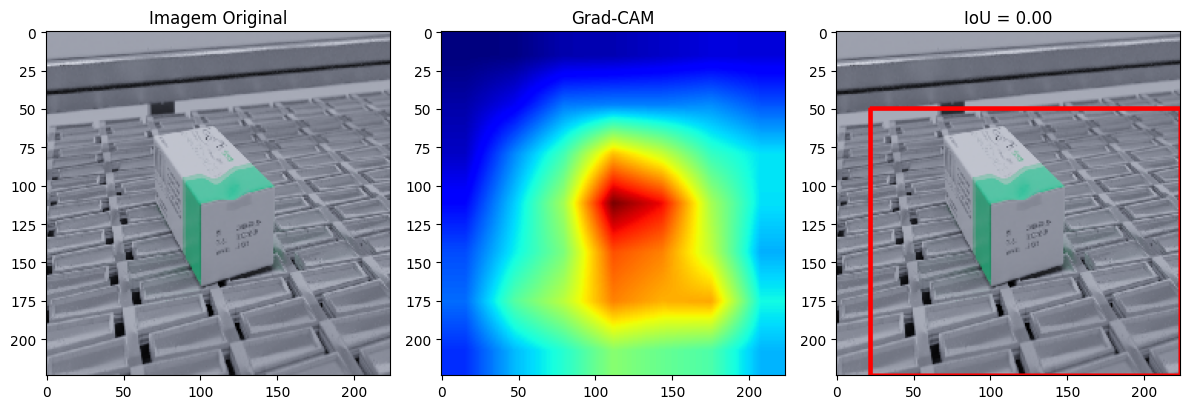

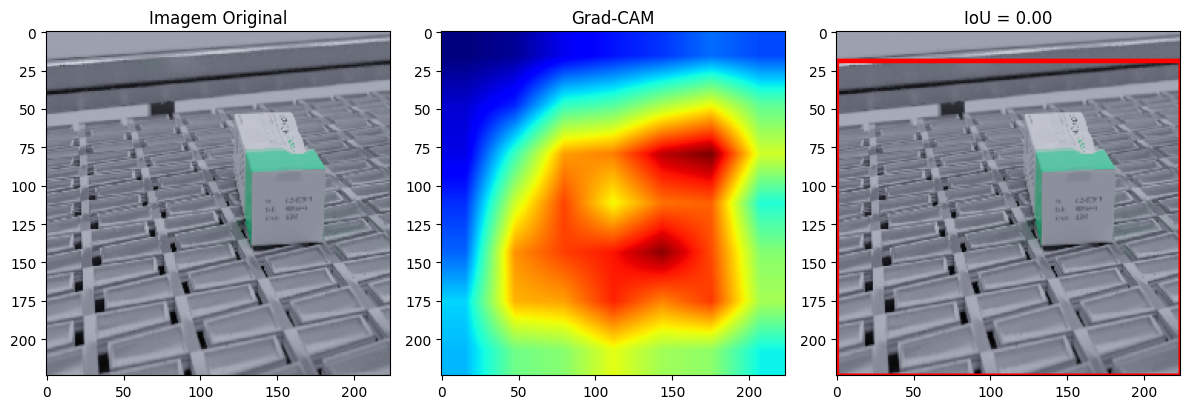

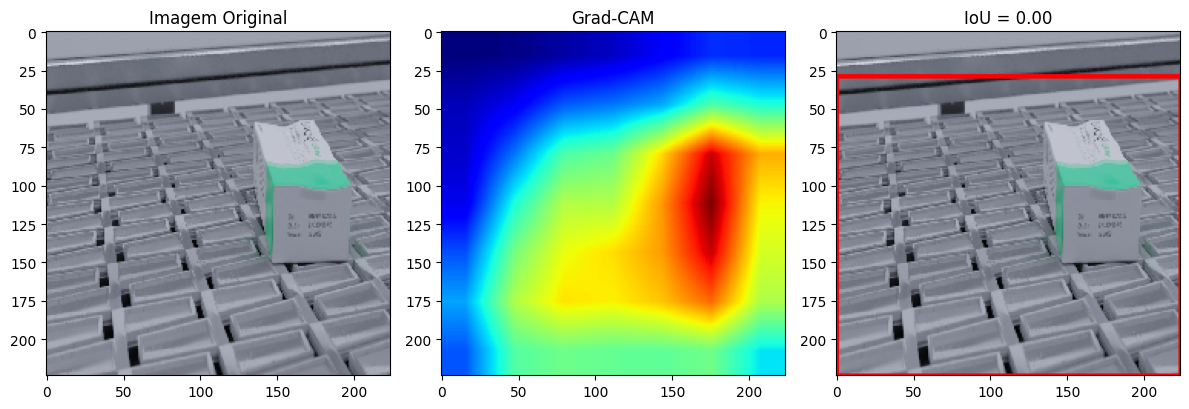

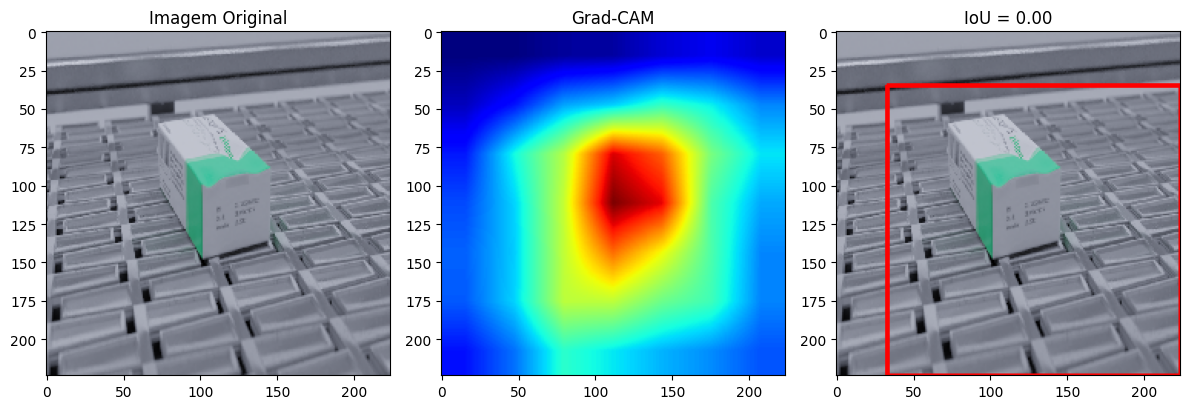

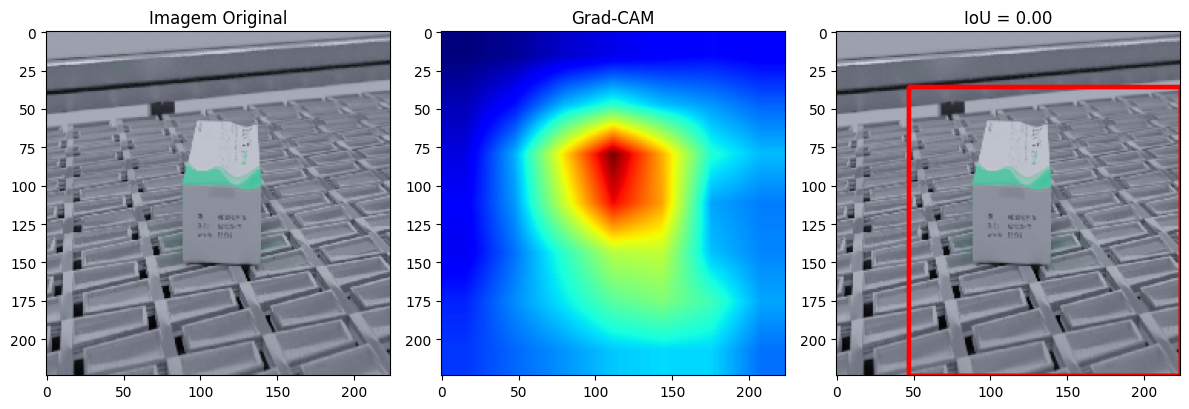

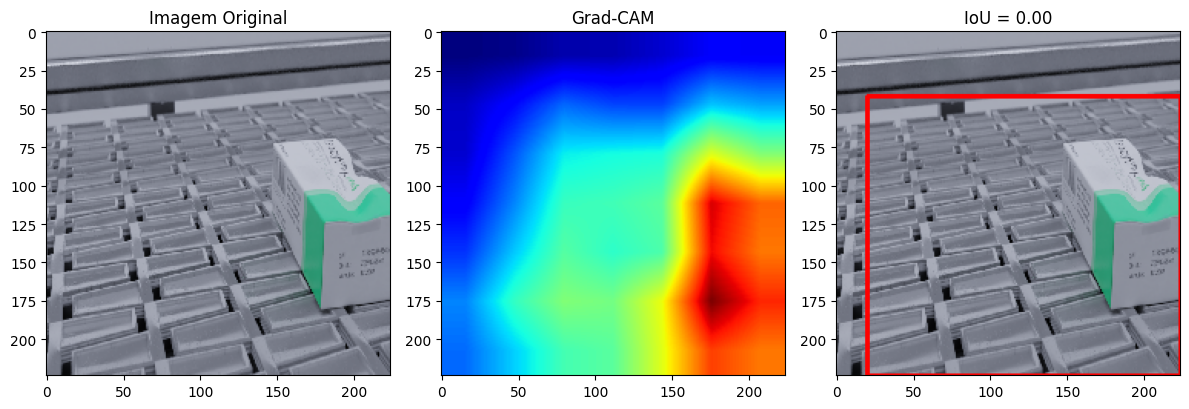

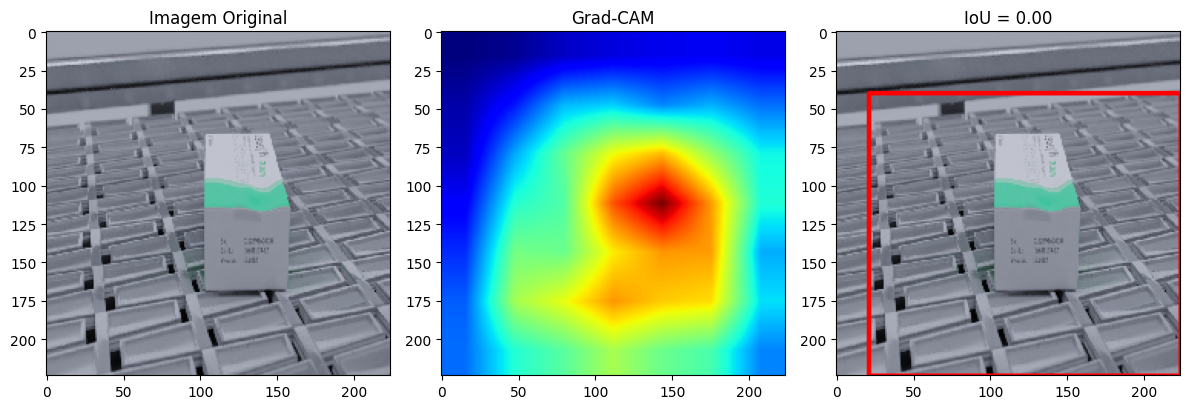

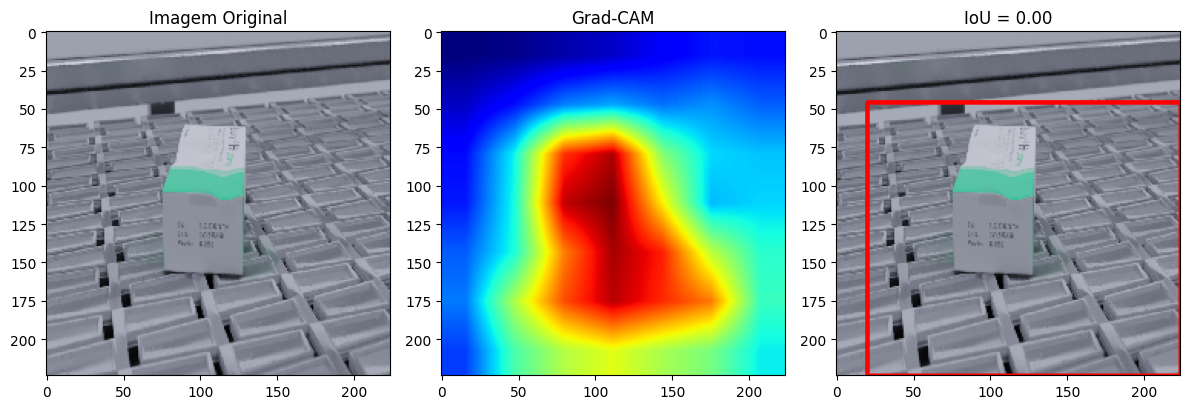

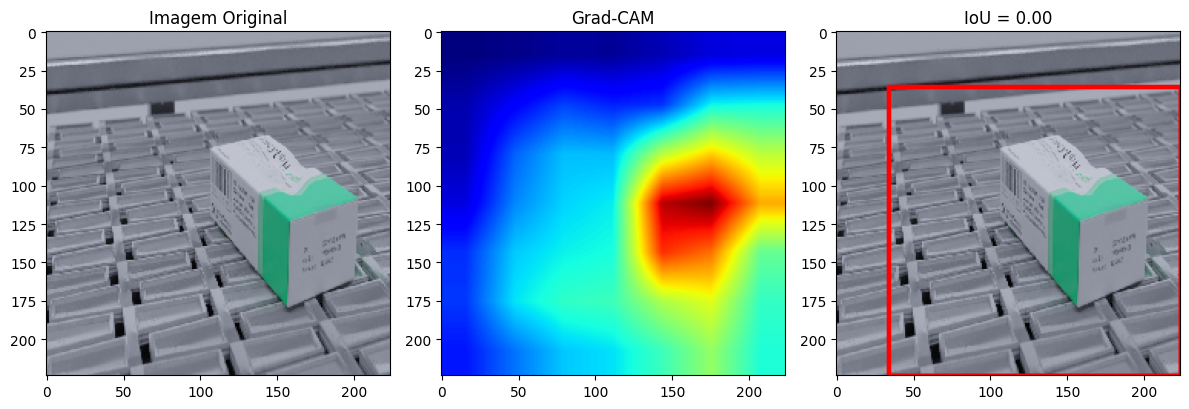

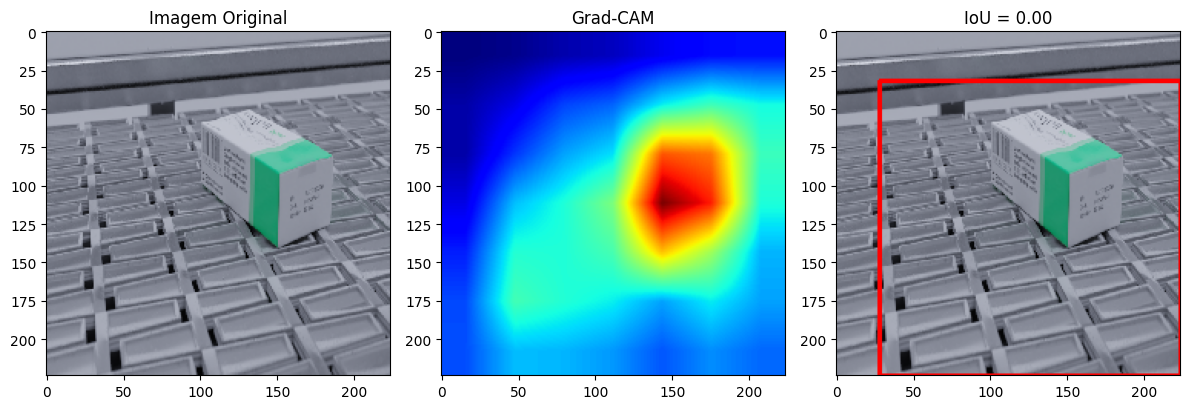

[INFO] Média final de IoU: 0.0000
IoU médio: 0.0
IoU acima de 0.5: 0 / 10


In [129]:
from tensorflow.keras.models import load_model  # ou use o modelo atual se já estiver carregado
from tensorflow.keras.preprocessing import image
import glob

# Caminhos
image_paths = sorted(glob.glob("interpretabilidade/damaged/side/*.png"))
xml_base_path = "interpretabilidade/damaged/side/"
model_cam = load_model("cam_supervised_model_final.h5")

# Avaliação
ious_new = evaluate_cam_alignment(model_cam, image_paths, xml_base_path)

# Estatísticas
print("IoU médio:", np.mean(ious_new))
print("IoU acima de 0.5:", np.sum(np.array(ious_new) > 0.5), "/", len(ious_new))


In [76]:
model.get_layer("resnet50").summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### FIM

In [4]:
import xmltodict
from PIL import Image

img_file_path = 'interpretabilidade/damaged/side/0101069901524_side.png'
# Path to your XML file
xml_file_path = 'interpretabilidade/damaged/side/0101069901524_side.xml'

# Read and parse the XML file using xmltodict
with open(xml_file_path, 'rb') as xml_file:
    xml_data = xmltodict.parse(xml_file)

# Extract information from the parsed XML data
annotation = xml_data['annotation']
filename = annotation['filename']
size = annotation['size']
width = int(size['width'])
height = int(size['height'])

#Image size
print(size['width'], size['height'], size['depth'])

# Extract bounding box coordinates and labels
objects = annotation['object']
if not isinstance(objects, list):
    objects = [objects]  # Handling the case of a single object
for obj in objects:
    label = obj['name']
    bbox = obj['bndbox']
    xmin = int(bbox['xmin'])
    ymin = int(bbox['ymin'])
    xmax = int(bbox['xmax'])
    ymax = int(bbox['ymax'])

    print(f"Label: {label}, Bounding Box: ({xmin}, {ymin}, {xmax}, {ymax})")

Label: damage, Bounding Box: (377, 148, 517, 243)


('960', '540', '3')

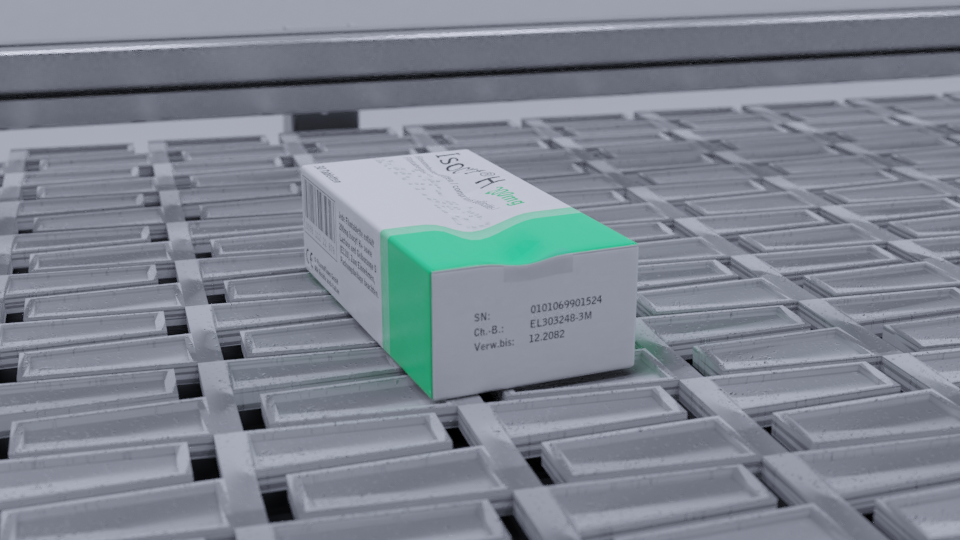

In [6]:
Image.open(img_file_path)